# Imports

In [1]:
import os
import sys
sys.path.append(os.path.expanduser('/rds/rds-clecat/generative_modelling/STL-Dev'))

In [2]:
import scipy.stats as stats

In [3]:
from astropy import units as u
from astropy.cosmology import Planck15

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.fft
import healpy as hp
from importlib import reload
from functools import partial
import sys
import healpy as hp

In [5]:
torch.cuda.is_available()

True

# Open the map

CIB

In [11]:
freq = 355 * u.GHz 
equiv = u.thermodynamic_temperature(freq, Planck15.Tcmb0)
1/( (1. * u.uK).to(u.Jy /u.sr, equivalencies=equiv) )

<Quantity 0.00341424 sr / Jy>

/tmp/ipykernel_1930632/3699519137.py:1: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  CIB353 = 0.003414237*hp.read_map('/rds/rds-clecat/generative_modelling/lensed_CIB_rot_BANDPASS_F353_three_params1.fits', dtype=None, verbose=False)


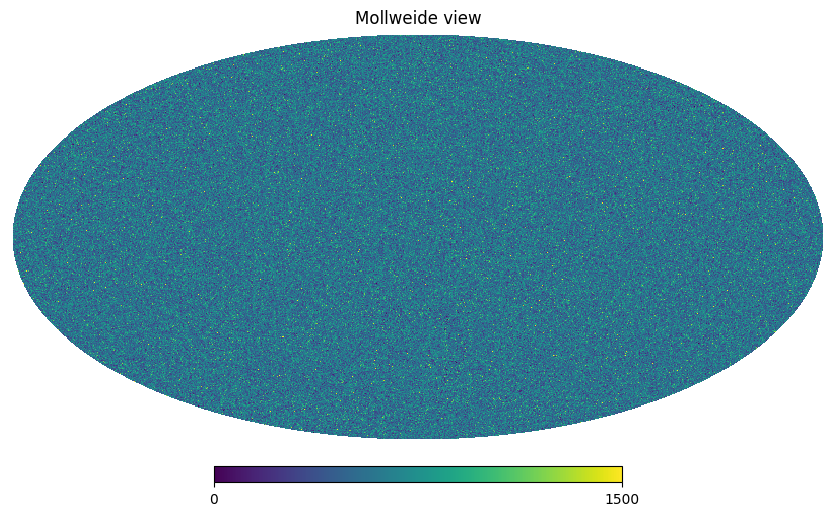

In [12]:
CIB353 = 0.003414237*hp.read_map('/rds/rds-clecat/generative_modelling/lensed_CIB_rot_BANDPASS_F353_three_params1.fits', dtype=None, verbose=False)
hp.mollview(CIB353, min=0, max=1.5e3)
plt.show()

In [13]:
nside = hp.get_nside(CIB353)
print("NSIDE =", nside)

NSIDE = 4096


The map resolution is : 1.72 arcmin


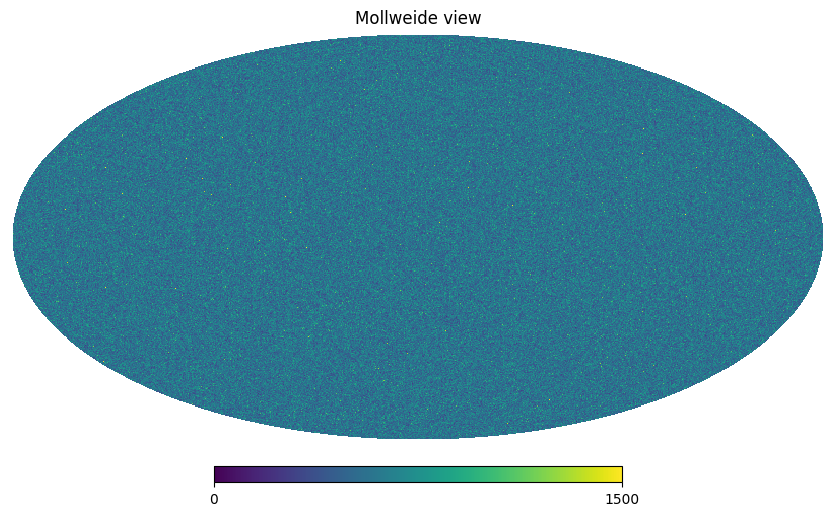

In [14]:
#Adapt the pixel size
nside = 2048
CIB_353 = hp.ud_grade(CIB353, nside_out=nside)

resol = hp.nside2resol(nside) # [rad]
resol_arcmin = np.rad2deg(resol) * 60
print('The map resolution is :', np.round(resol_arcmin, 2), 'arcmin')

hp.mollview(CIB_353, min= 0, max=1.5e3)
plt.show()

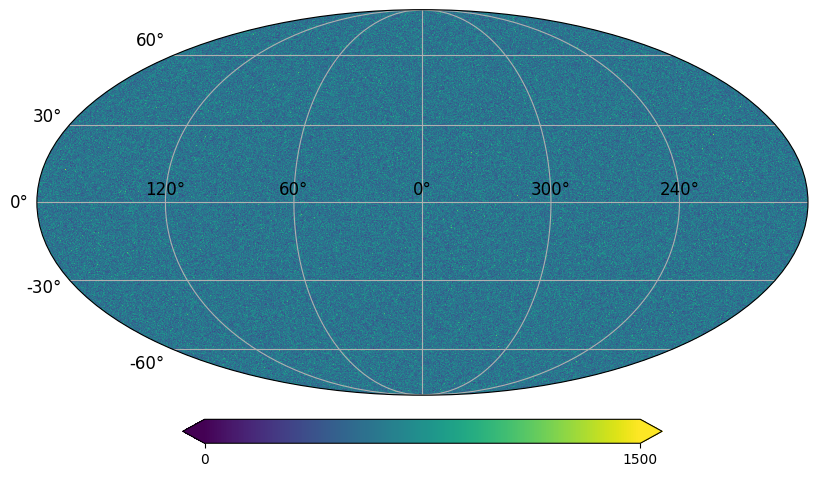

In [15]:
#Beam

SObeam_fwhm = np.deg2rad(1.4 / 60) # [rad] 

CIB353_smooth = hp.smoothing(np.array(CIB_353), fwhm=SObeam_fwhm)
hp.projview(CIB353_smooth, min=0, max=1.5e3, graticule=True, graticule_labels=True)

plt.show()

tSZ

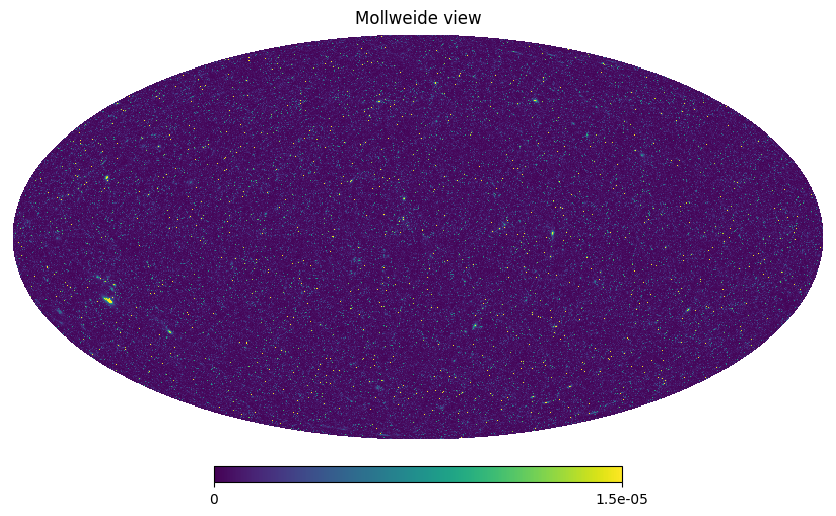

In [6]:
ymap = np.load('/rds/rds-clecat/generative_modelling/ymap_all_2048_190125.npy')
hp.mollview(ymap, min=0, max=1.5e-5)
plt.show()

In [7]:
nside = hp.get_nside(ymap)
print("NSIDE =", nside)

NSIDE = 2048


The map resolution is : 1.72 arcmin


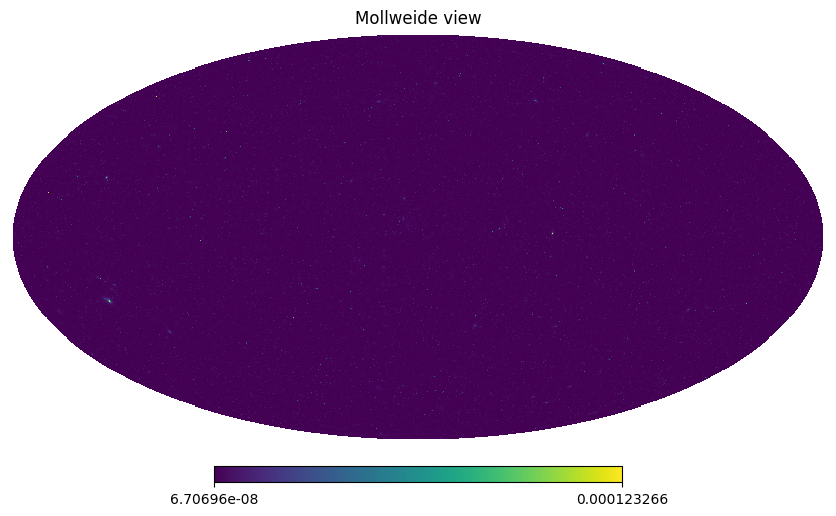

In [8]:
# Change the pixel size
nside = 2048
ymap = hp.ud_grade(ymap, nside_out=nside)

resol = hp.nside2resol(nside) # [rad]
resol_arcmin = np.rad2deg(resol) * 60
print('The map resolution is :', np.round(resol_arcmin, 2), 'arcmin')

hp.mollview(ymap)#, min= 0, max=1.5e3)
plt.show()

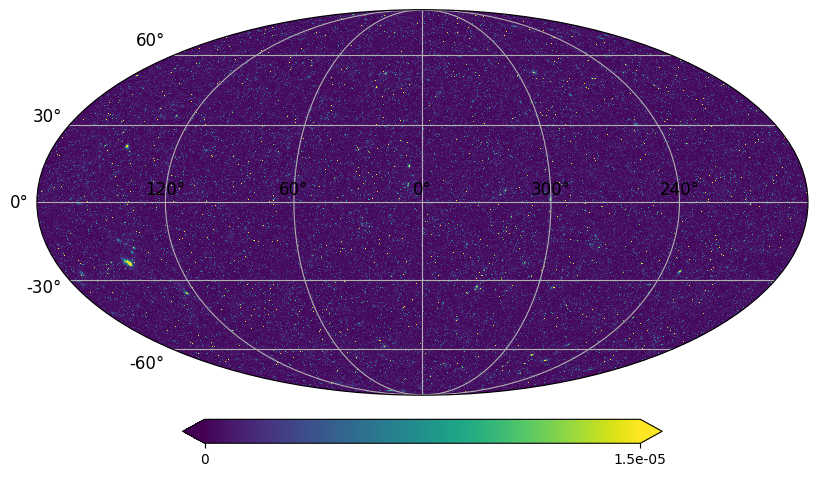

In [9]:
#Beam
SObeam_fwhm = np.deg2rad(1.4 / 60) # [rad] 

ymap_smooth = hp.smoothing(np.array(ymap), fwhm=SObeam_fwhm)
hp.projview(ymap_smooth, min=0, max=1.5e-5, graticule=True, graticule_labels=True)

plt.show()

Extract a patch

In [10]:
npix = 256
patch_size = 10  # degrees
reso_arcmin = patch_size * 60 / npix  # arcmin/pixel

In [11]:
#Center of the patch
lon0 = 0.0   # degrees
lat0 = 0.0   # degrees

proj = hp.projector.GnomonicProj(
    rot=(lon0, lat0, 0),
    coord='G',              
    reso=reso_arcmin,      
    xsize=npix,
    ysize=npix
)

# Extraction du patch
patch = proj.projmap(
    ymap_smooth, ##### OR CIB353 IF YOU ARE WORKING ON THE CIB
    vec2pix_func=partial(hp.vec2pix, nside)
)

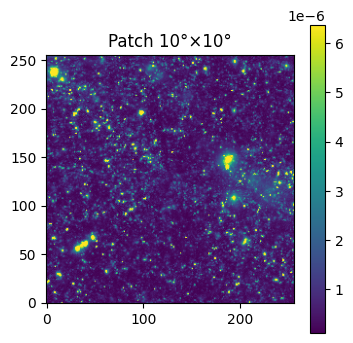

In [12]:
vmin, vmax = np.percentile(patch, [1, 99])

plt.figure(figsize=(4, 4))
im = plt.imshow(patch, vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar(im)
plt.title("Patch 10°×10°")
plt.show()

# Useful functions

Power spectrum

In [13]:
def power_spectrum(image):
    assert image.shape[0] == image.shape[1]    
    n = image.shape[0]

    fourier = np.fft.fftn(image)
    amplitude = (np.abs(fourier) ** 2).flatten()

    kfreq = np.fft.fftfreq(n) * n
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = (kfreq2D[0] ** 2 + kfreq2D[1] ** 2).flatten() ** (1 / 2)

    kbins = np.arange(1/2, n // 2 + 1, 1)
    kvals = (kbins[1:] + kbins[:-1]) / 2
    bins, _, _ = stats.binned_statistic(knrm, amplitude, statistic = "mean", bins = kbins)
    
    return kvals, bins

def plot_power_spectra(samples):
    """
    Plots the mean power spectra for given image samples, with error bars.

    Parameters:
        samples: List of tuples (sample_images, color, label)
            - sample_images: List of 2D numpy arrays (grayscale images)
            - color: Plot color
            - label: Legend label
    """

    plt.figure(figsize=(8, 6))  # Single plot for power spectra

    for sample_images, color, label in samples:
        power_spectra_full = []  # Stores bootstrapped power spectra

        # Compute power spectra for each image
        for image in sample_images:
            k, bins = power_spectrum(image)  # Function assumed to exist
            power_spectra_full.append(bins)

        # Convert to NumPy array
        power_spectra_full = np.array(power_spectra_full)

        if len(sample_images) == 1:
            # Plot for a single image (no uncertainty)
            plt.plot(k, power_spectra_full[0], label=label, color=color, alpha=1.0)

        else:
            # Compute mean and confidence intervals
            mean_power = np.mean(power_spectra_full, axis=0)
            lower_bound_68 = np.percentile(power_spectra_full, 16, axis=0)
            upper_bound_68 = np.percentile(power_spectra_full, 84, axis=0)
            lower_bound_95 = np.percentile(power_spectra_full, 2.5, axis=0)
            upper_bound_95 = np.percentile(power_spectra_full, 97.5, axis=0)

            # Plot power spectrum with error bands
            #plt.fill_between(k, lower_bound_95, upper_bound_95, color=color, alpha=0.3)
            plt.fill_between(k, lower_bound_68, upper_bound_68, color=color, alpha=0.5, label=label)
            plt.plot(k, mean_power, color=color, alpha=1.0)

    # Final plot formatting
    plt.xlabel(r"Wavenumber $k$")
    plt.ylabel(r"Power Spectrum $P(k)$")
    plt.xscale("log")  # Usually power spectra are shown in log scale
    plt.yscale("log")
    plt.legend()
    plt.title("Power Spectra with Confidence Intervals")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)

Nyquist filter

In [14]:
import numpy as np

def apply_low_pass_filter(image, k_cutoff=128):
    n = image.shape[0]
    
    f_coeffs = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_coeffs)
    
    y, x = np.ogrid[-n/2:n/2, -n/2:n/2]
    dist_from_center = np.sqrt(x**2 + y**2)
    
    mask = dist_from_center <= k_cutoff
    
    f_shifted_filtered = f_shifted * mask
    
    f_unshifted = np.fft.ifftshift(f_shifted_filtered)
    image_filtered = np.fft.ifft2(f_unshifted)
    
    return np.real(image_filtered)


Random map from FFT

In [15]:
def get_random_data(target, M, N, mode='image'):
    '''
    get a gaussian random field with the same power spectrum as the image 'target' (in the 'image' mode),
    or with an assigned power spectrum function 'target' (in the 'func' mode).
    '''
    
    if mode == 'func':
        random_phase = np.random.normal(0,1,(M//2-1,N-1)) + np.random.normal(0,1,(M//2-1,N-1))*1j
        random_phase_left = (np.random.normal(0,1,(M//2-1)) + np.random.normal(0,1,(M//2-1))*1j)[:,None]
        random_phase_top = (np.random.normal(0,1,(N//2-1)) + np.random.normal(0,1,(N//2-1))*1j)[None,:]
        random_phase_middle = (np.random.normal(0,1,(N//2-1)) + np.random.normal(0,1,(N//2-1))*1j)[None,:]
        random_phase_corners = np.random.normal(0,1,3)
    if mode == 'image':
        random_phase = np.random.rand(M//2-1,N-1)
        random_phase_left = np.random.rand(M//2-1)[:,None]
        random_phase_top = np.random.rand(N//2-1)[None,:]
        random_phase_middle = np.random.rand(N//2-1)[None,:]
        random_phase_corners = np.random.randint(0,2,3)/2
    gaussian_phase = np.concatenate((
                      np.concatenate((random_phase_corners[1][None,None],
                                      random_phase_left,
                                      random_phase_corners[2][None,None],
                                      -random_phase_left[::-1,:],
                                    ),axis=0),
                      np.concatenate((np.concatenate((random_phase_top,
                                                      random_phase_corners[0][None,None],
                                                      -random_phase_top[:,::-1],
                                                    ),axis=1),
                                      random_phase, 
                                      np.concatenate((random_phase_middle, 
                                                      np.array(0)[None,None], 
                                                      -random_phase_middle[:,::-1],
                                                    ),axis=1), 
                                      -random_phase[::-1,::-1],
                                    ),axis=0),
                                    ),axis=1)
    

    if mode == 'image':
        gaussian_modulus = np.abs(np.fft.fftshift(np.fft.fft2(target)))
        gaussian_field = np.fft.ifft2(np.fft.fftshift(gaussian_modulus*np.exp(1j*2*np.pi*gaussian_phase)))
    if mode == 'func':
        X = np.arange(0,M)
        Y = np.arange(0,N)
        Xgrid, Ygrid = np.meshgrid(X,Y)
        R = ((Xgrid-M/2)**2+(Ygrid-N/2)**2)**0.5
        gaussian_modulus = target(R)
        gaussian_modulus[M//2, N//2] = 0
        gaussian_field = np.fft.ifft2(np.fft.fftshift(gaussian_modulus*gaussian_phase))
        
    data = np.fft.fftshift(np.real(gaussian_field))
    return data

Apodisation

In [16]:
import numpy as np

def tukey_1d(N, alpha=0.2):
    """
    Fenêtre de Tukey 1D (NumPy pur)
    
    alpha = fraction du signal apodisée (0 → rectangulaire, 1 → Hanning)
    """
    if alpha <= 0:
        return np.ones(N)
    if alpha >= 1:
        return np.hanning(N)

    w = np.ones(N)
    edge = int(alpha * (N - 1) / 2)

    n = np.arange(edge)
    taper = 0.5 * (1 - np.cos(np.pi * n / edge))

    w[:edge] = taper
    w[-edge:] = taper[::-1]

    return w

In [17]:
def tukey_2d(shape, alpha=0.2):
    h, w = shape[-2:]
    wy = tukey_1d(h, alpha)
    wx = tukey_1d(w, alpha)
    return np.outer(wy, wx)

White noise method

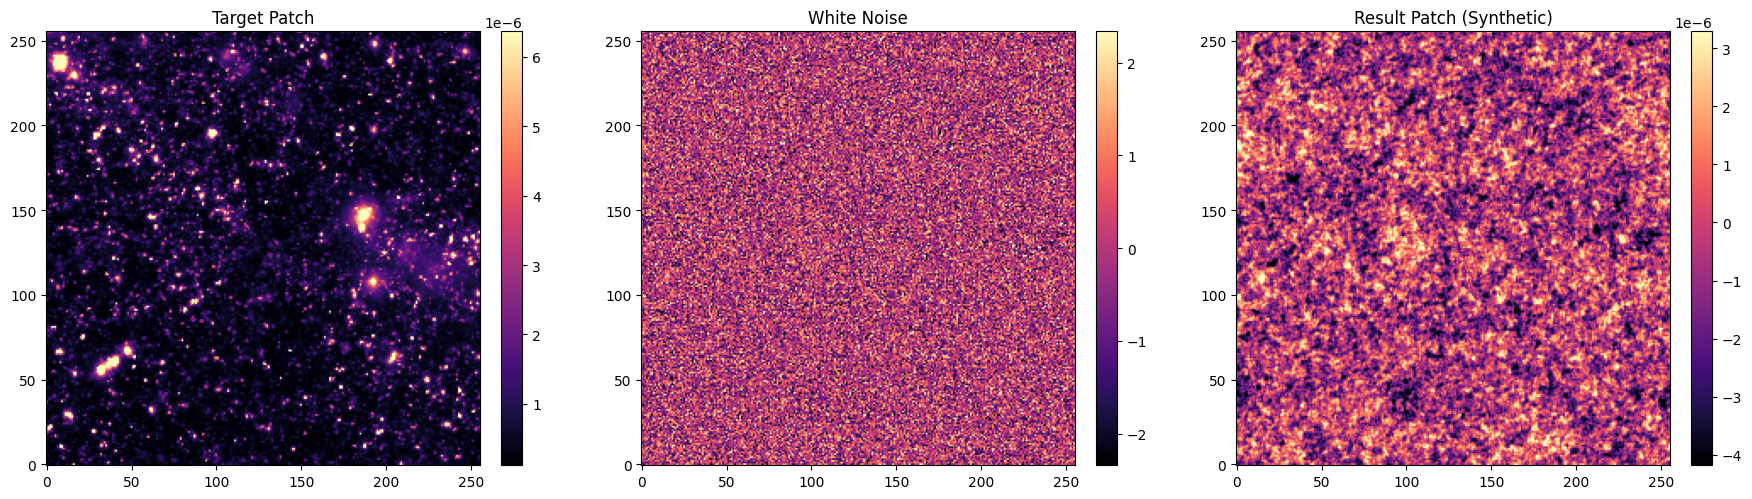

array([[-2.53055735e-06, -2.59358515e-06, -1.66255482e-06, ...,
        -8.89228771e-07, -1.35249989e-06, -1.41810901e-06],
       [-2.98908363e-06, -2.80524902e-06, -2.48053355e-06, ...,
        -1.93090506e-07, -1.45708762e-06, -2.63127596e-06],
       [-1.62397375e-06, -5.72545762e-07, -2.31064707e-06, ...,
         2.03461299e-06,  7.18900886e-07, -4.18100913e-07],
       ...,
       [-2.27141370e-06, -8.79495450e-07,  1.61119925e-06, ...,
        -8.12169716e-07, -2.90771048e-06, -2.58064704e-06],
       [-8.07609509e-07, -1.55963727e-06, -2.58648676e-07, ...,
        -2.20567597e-06, -2.61763571e-06, -3.05057998e-06],
       [-7.60686409e-07,  5.06168033e-07,  2.50508629e-07, ...,
        -1.84994162e-06, -7.83397865e-07, -1.59915073e-06]])

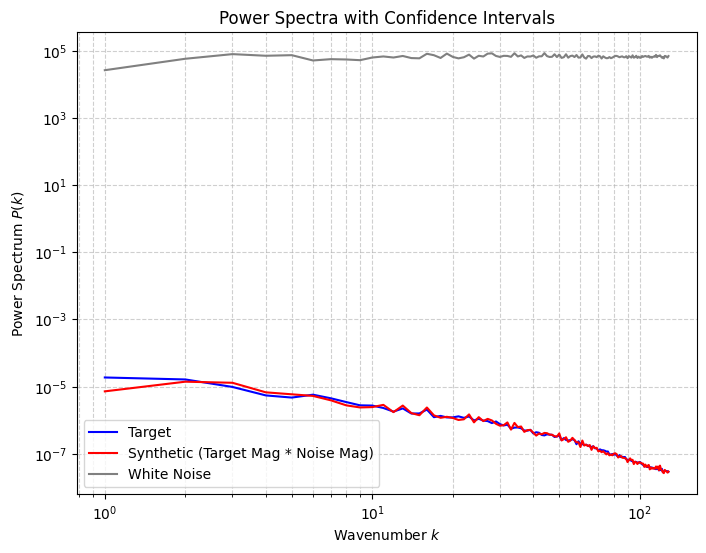

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_map(target_patch):
    size = target_patch.shape[0]
    white_noise = np.random.normal(0, 1, (size, size))

    fft_target = np.fft.fftn(target_patch, norm="ortho")
    fft_noise = np.fft.fftn(white_noise, norm="ortho")

    mag_target = np.abs(fft_target)
    mag_noise = np.abs(fft_noise)
    phase_noise = np.angle(fft_noise)

    combined_amplitude = mag_target * mag_noise
    new_fft = combined_amplitude * np.exp(1j * phase_noise)

    result_patch = np.fft.ifftn(new_fft, norm="ortho").real

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    titles = ["Target Patch", "White Noise", "Result Patch (Synthetic)"]
    datas = [target_patch, white_noise, result_patch]

    for i, ax in enumerate(axes):
        vmin, vmax = np.percentile(datas[i], [1, 99])
        
        im = ax.imshow(datas[i], vmin=vmin, vmax=vmax, origin='lower', cmap='magma')
        ax.set_title(titles[i])
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    
    plot_power_spectra([
    ([target_patch], "blue", "Target"),
    ([result_patch], "red", "Synthetic (Target Mag * Noise Mag)"),
    ([white_noise], "gray", "White Noise")
    ])

    return result_patch

gaussian_map(patch)

PDF

In [19]:
def plot_pdf(samples, num_bins=50, range=(-1, 60)):
    """
    Plots the probability density function (PDF) for given image samples with confidence intervals.

    Parameters:
        samples: List of tuples (sample_images, color, label)
            - sample_images: List of 2D numpy arrays (grayscale images)
            - color: Plot color
            - label: Legend label
        num_bins: Number of bins for histogram (default: 50)
    """

    plt.figure(figsize=(8, 6))  # Single plot for PDFs

    for sample_images, color, label in samples:
        pdfs_full = []  # Stores bootstrapped PDFs
        bin_edges = None  # Store bins

        # Compute PDF for each image
        for image in sample_images:
            pixel_values = image.flatten()  # Flatten image to 1D
            hist, bin_edges = np.histogram(pixel_values, bins=num_bins, range=range, density=True)  # Compute PDF
            pdfs_full.append(hist)

        # Convert to NumPy array
        pdfs_full = np.array(pdfs_full)

        # Compute bin centers
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        bw = bin_centers[1] - bin_centers[0]

        if len(sample_images) == 1:
            # Plot for a single image (no uncertainty)
            plt.plot(bin_centers, pdfs_full[0]*bw, label=label, color=color, alpha=1.0)

        else:
            # Compute mean and confidence intervals
            mean_pdf = np.mean(pdfs_full*bw, axis=0)
            lower_bound_68 = np.percentile(pdfs_full*bw, 16, axis=0)
            upper_bound_68 = np.percentile(pdfs_full*bw, 84, axis=0)
            lower_bound_95 = np.percentile(pdfs_full*bw, 2.5, axis=0)
            upper_bound_95 = np.percentile(pdfs_full*bw, 97.5, axis=0)

            # Plot PDF with error bands
            #plt.fill_between(bin_centers, lower_bound_95, upper_bound_95, color=color, alpha=0.3)
            plt.fill_between(bin_centers, lower_bound_68, upper_bound_68, color=color, alpha=0.5, label=label)
            plt.plot(bin_centers, mean_pdf, color=color, alpha=1.0)

    # Final plot formatting
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Probability Density Function (PDF)")
    plt.yscale("log")  # Often PDFs have a large dynamic range
    plt.legend()
    plt.title("PDF of Pixel Intensities with Confidence Intervals")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    #plt.show()


# Synthesis

Target patch

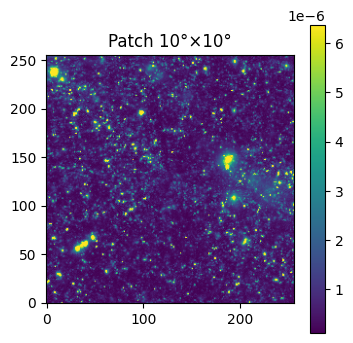

In [20]:
vmin, vmax = np.percentile(patch, [1, 99])

plt.figure(figsize=(4, 4))
im = plt.imshow(patch, vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar(im)
plt.title("Patch 10°×10°")
plt.show()

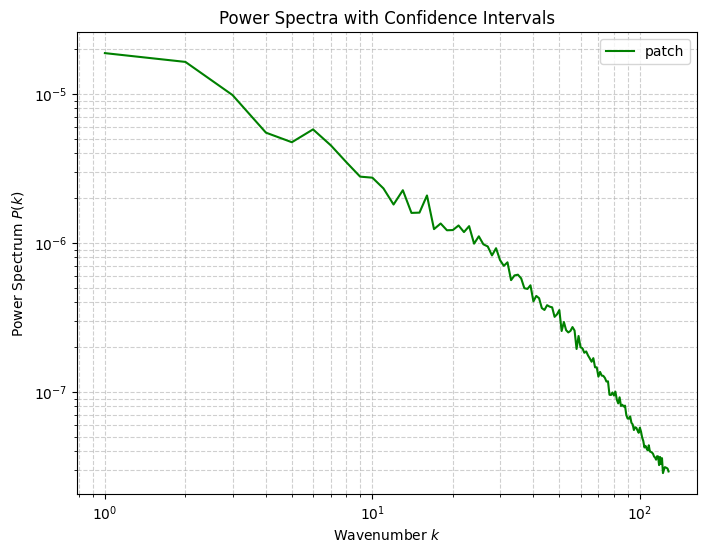

In [21]:
plot_power_spectra([([patch], "green", "patch")])
plt.show()

Gaussian method

In [22]:
num_pixel = patch.shape[0]
gaussian_patch = get_random_data(
    patch,
    num_pixel,
    num_pixel,
    mode="image"
)

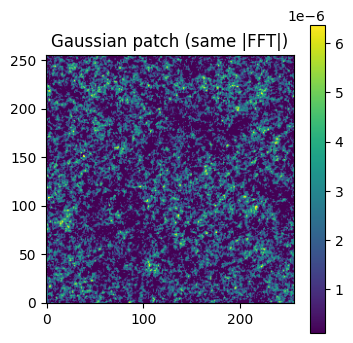

In [23]:
vmin, vmax = np.percentile(patch, [1, 99])

plt.figure(figsize=(4,4))
im = plt.imshow(gaussian_patch, origin="lower", vmin =vmin, vmax =vmax)
plt.colorbar(im)
plt.title("Gaussian patch (same |FFT|)")
plt.show()

# Analysis

Power spectrum

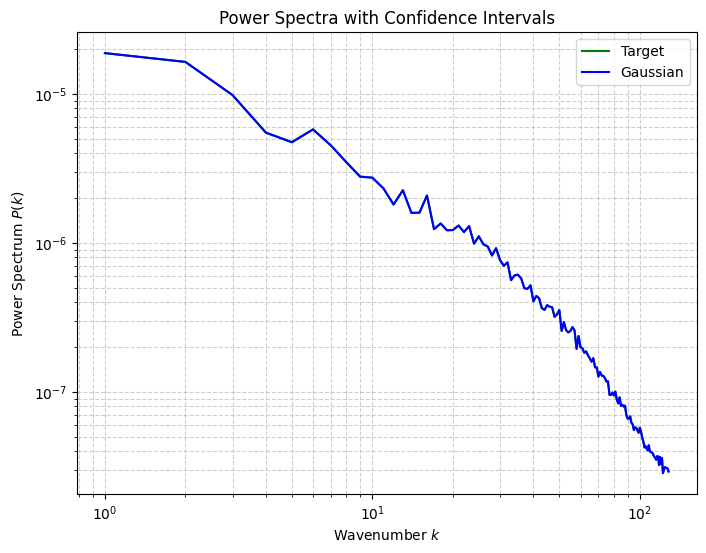

In [24]:
plot_power_spectra([
    ([patch], "green", "Target"),
    ([gaussian_patch], "b", "Gaussian"),
])
plt.show()

PDF

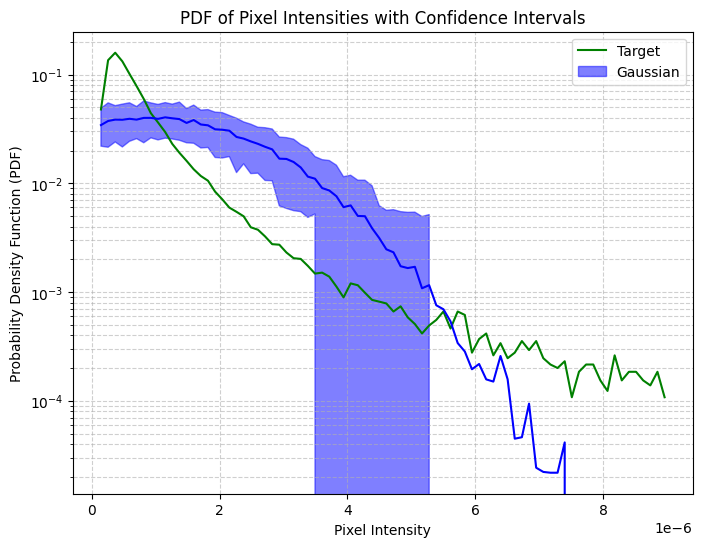

In [25]:
lo = np.percentile(patch, 0.5)
hi = np.percentile(patch, 99.5)

plot_pdf(
    [
        ([patch], "green", "Target"),
        (gaussian_patch, "b", "Gaussian"),
    ],
    num_bins=80,
    range=(lo, hi))
plt.show()

Fit a gaussian curve on the PDF of the Gaussian map

Same method, multiple patches generated

In [26]:
num_pixel = patch.shape[0]

gaussian_patches = []

for i in range(5):
    gaussian_patch = get_random_data(
        patch,
        num_pixel,
        num_pixel,
        mode="image"
    )
    gaussian_patches.append(gaussian_patch)

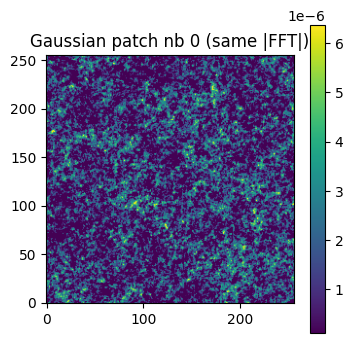

In [27]:
vmin, vmax = np.nanpercentile(patch, [1, 99])
plt.figure(figsize=(4,4))
plt.imshow(gaussian_patches[0], origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("Gaussian patch nb 0 (same |FFT|)")
plt.show()

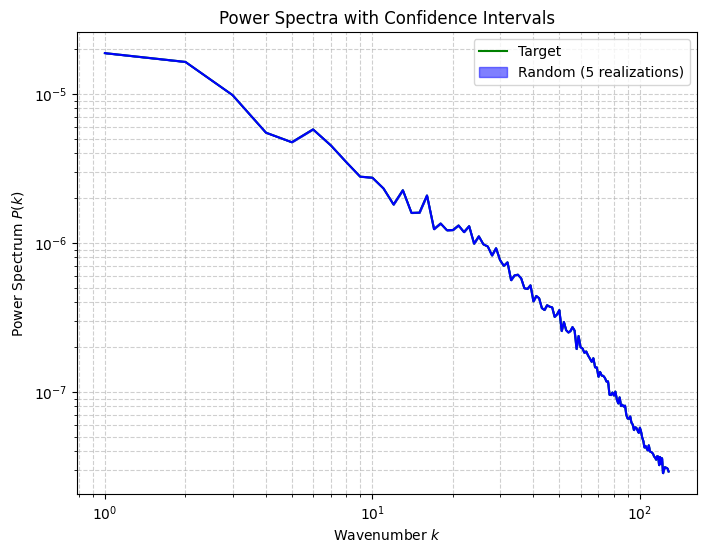

In [28]:
plot_power_spectra([
    ([patch], "green", "Target"),
    (gaussian_patches, "b", "Random (5 realizations)"),
])
plt.show()

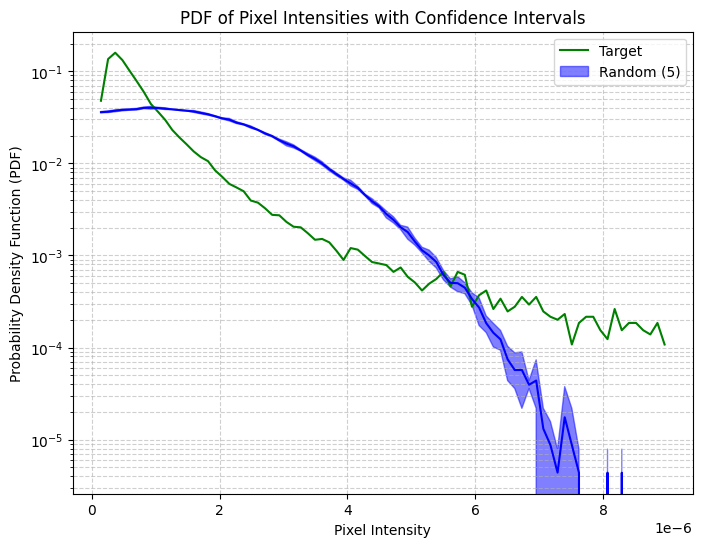

In [29]:
lo = np.percentile(patch, 0.5)
hi = np.percentile(patch, 99.5)

plot_pdf(
    [
        ([patch], "green", "Target"),
        (gaussian_patches, "b", "Random (5)"),
    ],
    num_bins=80,
    range=(lo, hi)
)
plt.show()

# Benchmark models

In [30]:
from STL_main.STL_2D_Kernel_Torch import STL_2D_Kernel_Torch as DataClass
from STL_main.ST_Operator import ST_Operator as SO
from STL_main.Synthesis import optimize_scattering_LBFGS

In [31]:
target_data = DataClass(patch)
st_op_target = SO(target_data)

In [32]:
st_op_running = SO(target_data)

In [33]:
seed = 42

u, histo = optimize_scattering_LBFGS(
    patch,          #target
    DataClass,
    st_op_target=st_op_target,
    st_op_running=st_op_running,
    nbatch=4,
    max_iter=1200,          
    lr=0.01,
    history_size=50,
    print_iter=20,
    verbose=True,
    seed=seed,
)

Running synthesis on device cuda:0 dtype torch.float64
synthesis on 3968 ST coefficients
[LBFGS] inner iter 20, loss = 5.061334e+23
[LBFGS] inner iter 40, loss = 3.595426e+22
[LBFGS] inner iter 60, loss = 3.430921e+21
[LBFGS] inner iter 80, loss = 2.540163e+20
[LBFGS] inner iter 100, loss = 1.825621e+19
[LBFGS] inner iter 120, loss = 1.799269e+18
[LBFGS] inner iter 140, loss = 1.398390e+17
[LBFGS] inner iter 160, loss = 1.042908e+16
[LBFGS] inner iter 180, loss = 1.020543e+15
[LBFGS] inner iter 200, loss = 7.069470e+13
[LBFGS] inner iter 220, loss = 4.378966e+12
[LBFGS] inner iter 240, loss = 3.513754e+11
[LBFGS] inner iter 260, loss = 2.125170e+10
[LBFGS] inner iter 280, loss = 1.203114e+09
[LBFGS] inner iter 300, loss = 9.367661e+07
[LBFGS] inner iter 320, loss = 5.484479e+06
[LBFGS] inner iter 340, loss = 3.046559e+05
[LBFGS] inner iter 360, loss = 2.338686e+04
[LBFGS] inner iter 380, loss = 1.357459e+03
[LBFGS] inner iter 400, loss = 9.557477e+01
[LBFGS] inner iter 420, loss = 6.58

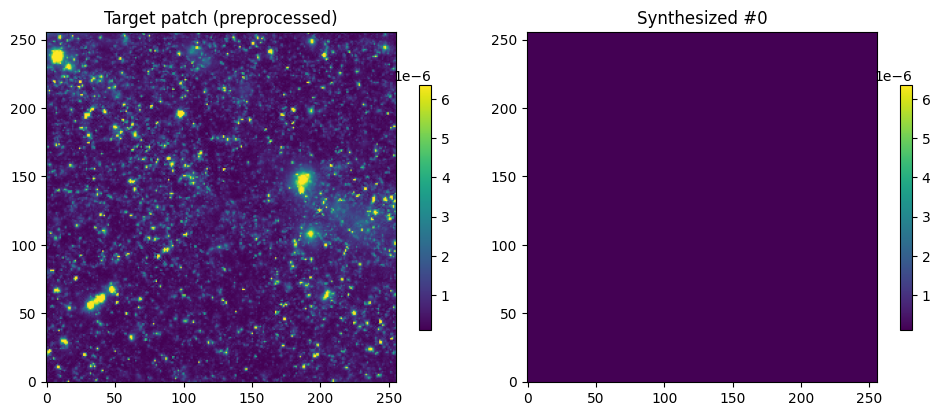

-0.0005053063570888157
1.6833726609468742e-06
1.6062846495537064e-06


In [34]:
plt.figure(figsize=(10,4))
vmin, vmax = np.nanpercentile(patch, [1, 99])

plt.subplot(1,2,1)
#plt.imshow(np.fft.fftshift(patch), origin="lower", vmin=vmin, vmax=vmax)
plt.imshow(patch, origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Target patch (preprocessed)")

plt.subplot(1,2,2)
plt.imshow(u[0].cpu().numpy() + patch.mean(), origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Synthesized #0")

plt.tight_layout()
plt.show()

print(np.mean(u[0].cpu().numpy()))
print(np.std(u[0].cpu().numpy()))
print(np.std(patch))

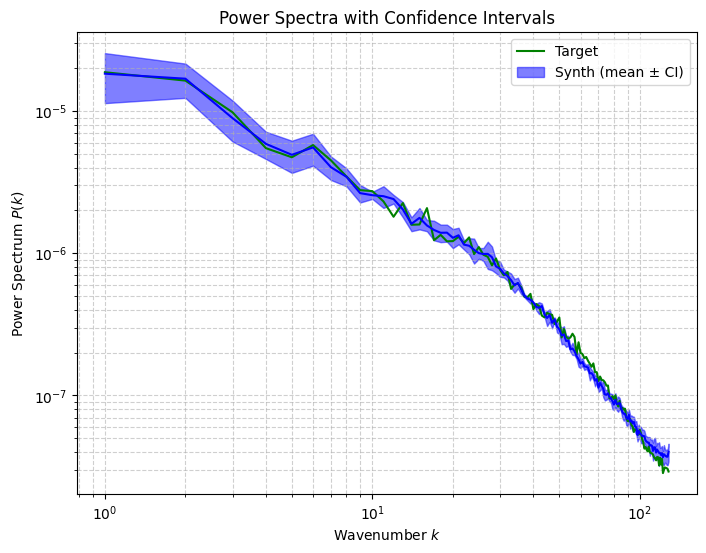

In [35]:
synth_patches = [u[k].detach().cpu().numpy() for k in range(u.shape[0])]
plot_power_spectra([
    ([patch], "green", "Target"),
    (synth_patches, "b", "Synth (mean ± CI)"),
])
plt.show()

/rds/rds-clecat/pipeline_alina_full/alina_paper/pipe_env/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


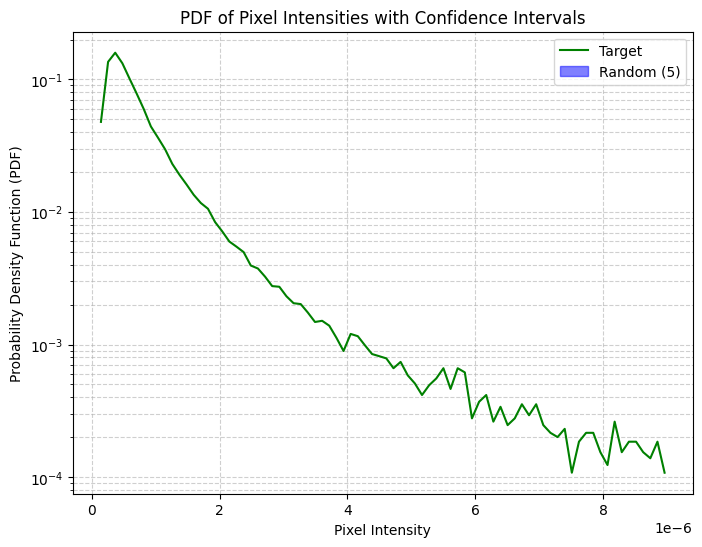

In [36]:
lo = np.percentile(patch, 0.5)
hi = np.percentile(patch, 99.5)

plot_pdf(
    [
        ([patch], "green", "Target"),
        (synth_patches, "b", "Random (5)"),
    ],
    num_bins=80,
    range=(lo, hi)
)
plt.show()

In [37]:
synth_patches_filtered = [apply_low_pass_filter(p, k_cutoff=128) for p in synth_patches]

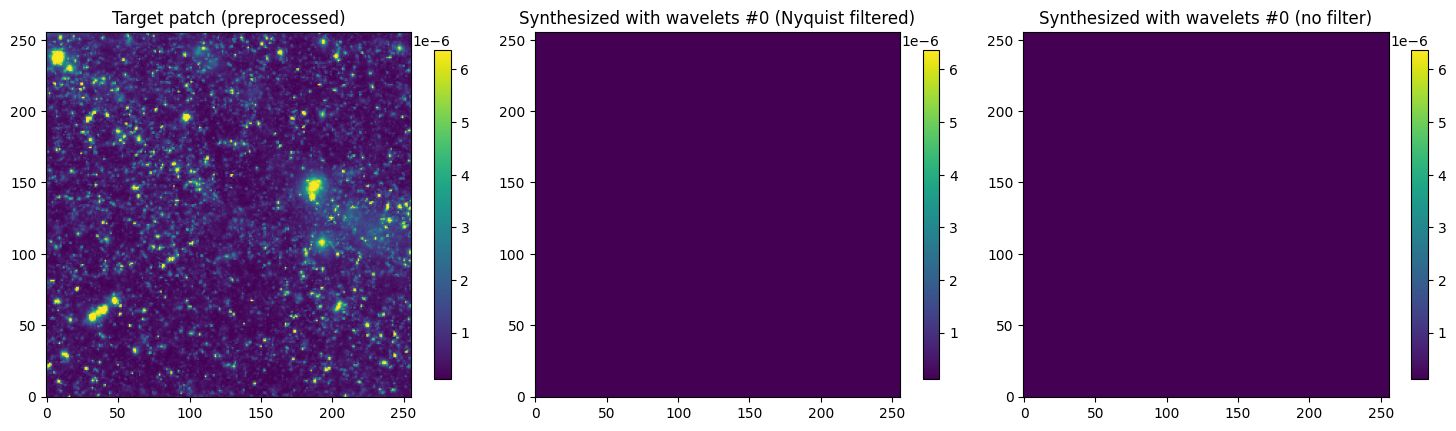

Mean Patch: 9.175061053519368e-07
variance target: 1.6062846495537064e-06
variance synthetized patch with nyquist filter: 1.6260681445472784e-06
variance synthetized patch without nyquist filter: 1.6833726609468742e-06


In [38]:
plt.figure(figsize=(15, 5)) 
vmin, vmax = np.nanpercentile(patch, [1, 99])

plt.subplot(1, 3, 1) 
plt.imshow(patch, origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Target patch (preprocessed)")

plt.subplot(1, 3, 2) 
plt.imshow(synth_patches_filtered[0] + patch.mean(), origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Synthesized with wavelets #0 (Nyquist filtered)")

plt.subplot(1, 3, 3) 
plt.imshow(u[0].cpu().numpy() + patch.mean(), origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Synthesized with wavelets #0 (no filter)")

plt.tight_layout()
plt.show()

print(f"Mean Patch: {np.mean(patch)}")
print("variance target:", np.std(patch))
print('variance synthetized patch with nyquist filter:' , np.std(synth_patches_filtered[0]))
print('variance synthetized patch without nyquist filter:' , np.std(u[0].cpu().numpy()))

Take into account non-periodicity

# Compare synthesis methods

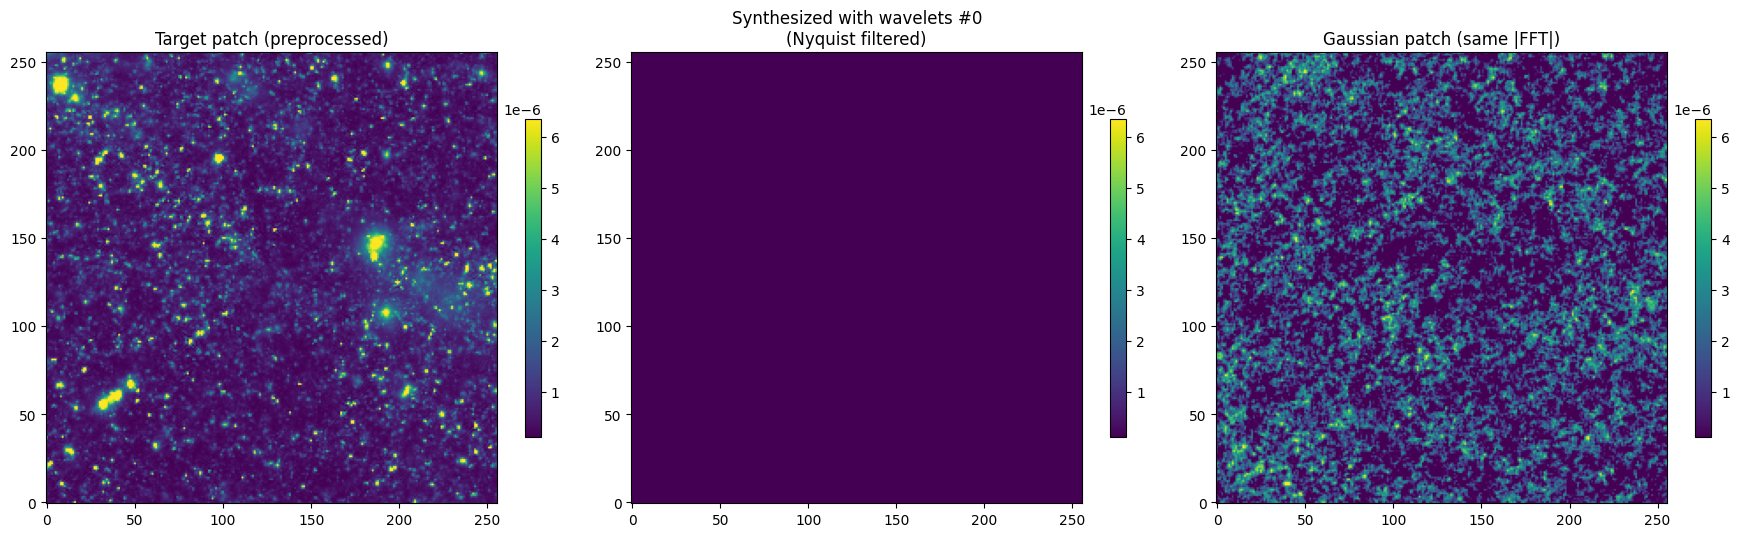

In [39]:
plt.figure(figsize=(18, 5)) 
vmin, vmax = np.nanpercentile(patch, [1, 99])

plt.subplot(1, 3, 1) 
plt.imshow(patch, origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Target patch (preprocessed)")

plt.subplot(1, 3, 2) 
plt.imshow(synth_patches_filtered[0] + patch.mean(), origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Synthesized with wavelets #0\n(Nyquist filtered)")

plt.subplot(1, 3, 3) # On utilise le 3ème emplacement
plt.imshow(gaussian_patch, origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Gaussian patch (same |FFT|)")

plt.tight_layout() 
plt.show()

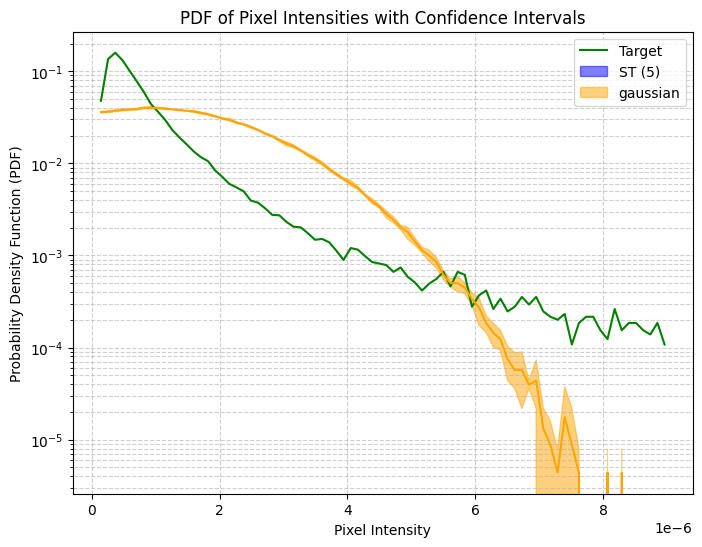

In [40]:
lo = np.percentile(patch, 0.5)
hi = np.percentile(patch, 99.5)

plot_pdf(
    [
        ([patch], "green", "Target"),
        (synth_patches, "b", "ST (5)"),
        (gaussian_patches, 'orange', "gaussian")
    ],
    num_bins=80,
    range=(lo, hi)
)
plt.show()

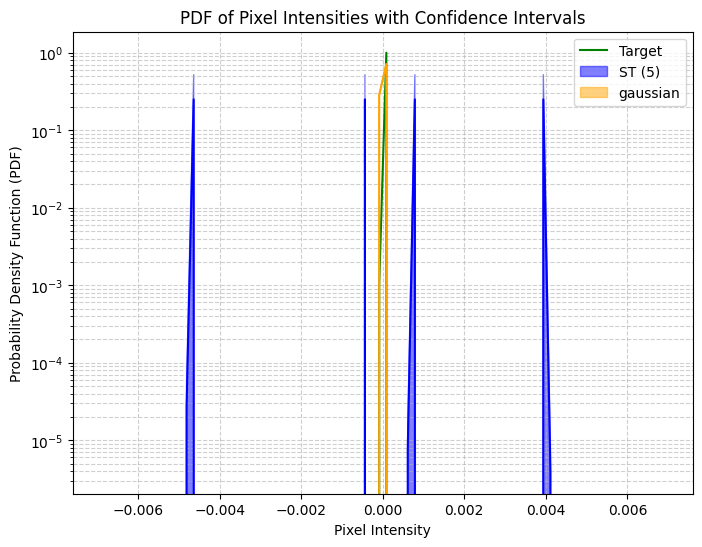

In [48]:
lo = np.percentile(patch, 0.5)
hi = np.percentile(patch, 99.5)

plot_pdf(
    [
        ([patch], "green", "Target"),
        (synth_patches, "b", "ST (5)"),
        (gaussian_patches, 'orange', "gaussian")
    ],
    num_bins=80,
    range=(-7e-3, 7e-3)
)
plt.show()

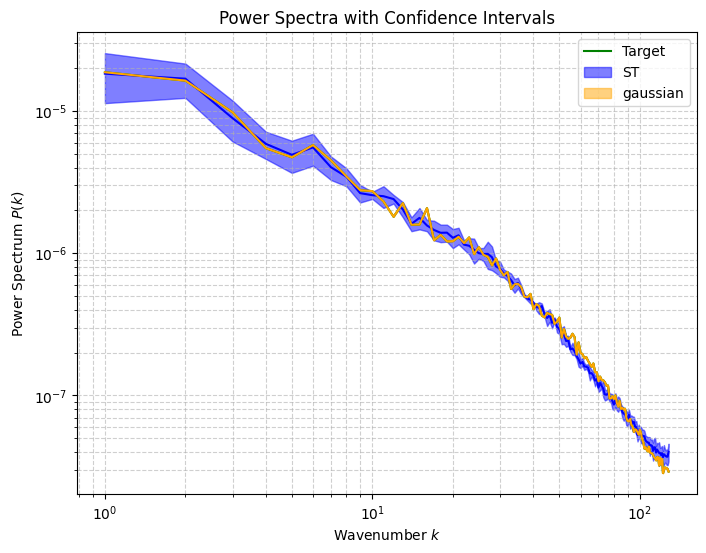

In [41]:
# u : tensor de shape (nbatch, H, W) eg
synth_patches = [u[k].detach().cpu().numpy() for k in range(u.shape[0])]
plot_power_spectra([
    ([patch], "green", "Target"),
    (synth_patches, "b", "ST"),
    (gaussian_patches, 'orange',"gaussian")
])
plt.show()

# Sanity checks

Check the effect of the apodisation window on the power spectrum

In [42]:
def run_validation_test(n_sims=70, N=256, alpha=0.15):
    shape = (N, N)
    window = tukey_2d(shape, alpha=alpha)

    # Important : moyenne de w^2 (pas la somme)
    w2_mean = np.mean(window**2)

    imgs_raw = []
    imgs_win = []

    for _ in range(n_sims):
        noise = np.random.normal(0, 1, shape)

        # Cas A : bruit brut normalisé pour que P(k) ~ 1 avec ta power_spectrum
        # (puisque power_spectrum renvoie ~ N^2 * Var(image))
        noise_raw = noise / N
        imgs_raw.append(noise_raw)

        # Cas B : fenêtré + correction énergie fenêtre (omega^2)
        # var(noise*window) = var(noise_raw) * <w^2>
        # donc on divise par sqrt(<w^2>) pour revenir au même niveau
        noise_win = (noise / N) * window / np.sqrt(w2_mean)
        imgs_win.append(noise_win)

    samples_to_plot = [
        (imgs_raw, 'blue', 'White noise with no window'),
        (imgs_win, 'orange', r'White noise (Tukey (alpha=0.2) / $\omega^2$)'),
    ]

    plot_power_spectra(samples_to_plot)

    plt.axhline(1, color='red', linestyle='--', label='Theory (Var=1)')
    plt.legend()
    plt.title(f"Checking correction to non periodicity ({n_sims} sims)")
    plt.show()

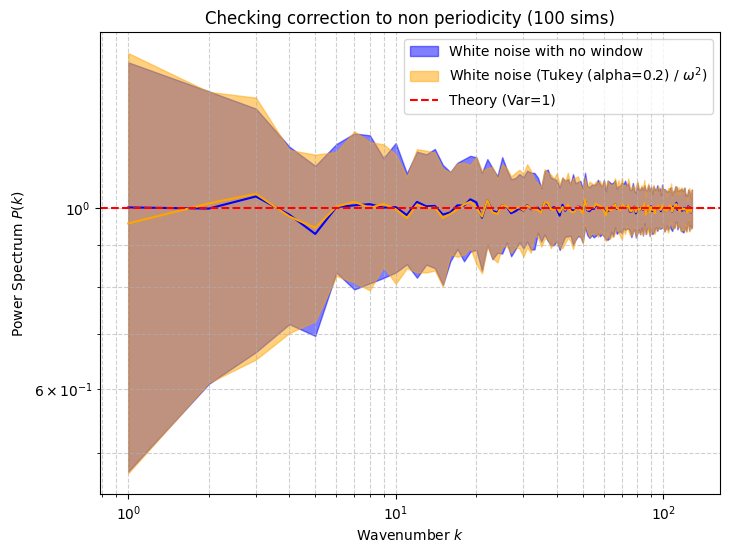

In [43]:
run_validation_test(n_sims=100)